# Predcition of Hospital Admission Related to Sore Throat

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sore throat (throat).

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'throat_date_'+str(i), 'throat_ab_date_'+str(i), 'throat_ab_type_'+str(i),
                   'incdt_throat_date_'+str(i), 'admitted_throat_date_'+str(i), 'sgss_gp_cov_throat_date_'+str(i)]]
    
    #drop rows with no throat reord
    datum = datum[datum['throat_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with throat_i
    datum = datum[datum['sgss_gp_cov_throat_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'throat_date_'+str(i): 'throat_date', 'throat_ab_date_'+str(i): 'throat_ab_date', 
                           'throat_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_throat_date_'+str(i): 'incdt_throat_date', 'incdt_throat_type_'+str(i): 'incdt_throat_type',
                           'admitted_throat_date_'+str(i): 'admitted_throat_date',
                           'sgss_gp_cov_throat_date_'+str(i): 'sgss_gp_cov_throat_date'},
                inplace=True)
    
    return datum

In [5]:
#preparation of data for cox models
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    data_req = data[vars+vars_countinuous+vars_output]
    #encoding categorical data for cox models
    data_enc = data_req[vars+vars_countinuous].reset_index()
    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [6]:
#summary table of observation counts
def make_summary_table(infection, infection_type, data):
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
#summary table of hospitalised cases
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    #encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()

    #creating instance of one-hot-encoder
    enc = OneHotEncoder()
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [8]:
#build cox models
def cox_model_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #calculate and save ci
    ci = cph.concordance_index_
    a = open('../output/hospitalisation_prediction_'+infection+'/'+infection+'_'+infection_type+'_ci.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (ci)])

    return cph, data_train, data_test

In [9]:
#save coefficients (betas) and calculate sum of betas
def cox_betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    #save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv(directory+'hazard_ratios_'+betas_name, index=False)

    #transpose and sort covariates and coefficients
    covariatesT = covariates.T
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data

    #further cleaning up covariates to make them compatible with the encoded data
    covariates_list = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    covariates_list = [value.replace("'", "") for value in covariates_list] #removes double quotation mark 

    #match covariates_list (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(covariates_list)] 
    data = data.sort_index(axis = 1) #sort 

    #multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')

    #sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    
    #predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  

    #sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    #separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))

    #select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    #save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [10]:
def cox_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    #analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)

    #plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [11]:
#calculate and plot calibrations of cox models
def cox_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']

    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T 
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [12]:
#print outputs of cox models
def cox_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    #calculate concordance index
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    #save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [13]:
#build cox model with an additional binary variable for antibiotics
def cox_model_abs_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics 
    #predict cumulative hazard in day 30 in train dataset
    prob_pred_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_train.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_train['bins'] = pd.qcut(prob_pred_train['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_train = pd.merge(prob_pred_train, data_train[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_train = prob_pred_train.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_train.columns = ['bins', 'pred_mean_train', 'pred_sum', 'pred_count', 'ab_prob_mean_train', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin = prob_pred_groupby_bin_train[['pred_mean_train', 'ab_prob_mean_train']]

    #predict cumulative hazard in day 30 in test dataset
    prob_pred_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T
    prob_pred_test.columns = ['pred']
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_test['bins'] = pd.qcut(prob_pred_test['pred'], 10)
    #add a column for prescribed antibiotics
    prob_pred_test = pd.merge(prob_pred_test, data_test[infection+'_ab_date'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_groupby_bin_test = prob_pred_test.groupby('bins')[['pred', infection+'_ab_date']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_groupby_bin_test.columns = ['bins', 'pred_mean_test', 'pred_sum', 'pred_count', 'ab_prob_mean_test', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_groupby_bin[['pred_mean_test', 'ab_prob_mean_test']] = prob_pred_groupby_bin_test[['pred_mean_test', 'ab_prob_mean_test']]

    #save binned prob_pred, train and test combined
    prob_pred_groupby_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_groupby_bin_'+infection+'_'+infection_type+'.csv', index=False)

    return cph, data_train, data_test

In [14]:
#build cox model with an additional categorical variable for antibiotics
def cox_model_ab_type_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [15]:
#build cox models stratified with sex categories 
def cox_model_strat_sex_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [16]:
#build cox models stratified with age categories
def cox_model_strat_age_build(infection, infection_type, data): 
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

In [17]:
#build cox models stratified with time period categories 
def cox_model_strat_period_build(infection, infection_type, data):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + throat_ab_date")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    return cph, data_train, data_test

## 1- data preparation

In [18]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_throat.csv.gz')

In [19]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [20]:
#process 20 throats and concatenate them 
data_throat_1 = proc_infec_data(data,1)
data_throat_2 = proc_infec_data(data,2)
data_throat_3 = proc_infec_data(data,3)
data_throat_4 = proc_infec_data(data,4)
data_throat_5 = proc_infec_data(data,5)
data_throat_6 = proc_infec_data(data,6)
data_throat_7 = proc_infec_data(data,7)
data_throat_8 = proc_infec_data(data,8)
data_throat_9 = proc_infec_data(data,9)
data_throat_10 = proc_infec_data(data,10)
data_throat_11 = proc_infec_data(data,11)
data_throat_12 = proc_infec_data(data,12)
data_throat_13 = proc_infec_data(data,13)
data_throat_14 = proc_infec_data(data,14)
data_throat_15 = proc_infec_data(data,15)
data_throat_16 = proc_infec_data(data,16)
data_throat_17 = proc_infec_data(data,17)
data_throat_18 = proc_infec_data(data,18)
data_throat_19 = proc_infec_data(data,19)
data_throat_20 = proc_infec_data(data,20)

data_throat = pd.concat([data_throat_1, data_throat_2, data_throat_3, data_throat_4, data_throat_5, data_throat_6, data_throat_7, data_throat_8, data_throat_9, data_throat_10, data_throat_11, data_throat_12, data_throat_13, data_throat_14, data_throat_15, data_throat_16, data_throat_17, data_throat_18, data_throat_19, data_throat_20])
data_throat.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [21]:
##add variable season
#convert data types
data_throat['throat_date'] = data_throat['throat_date'].astype('datetime64[ns]')
data_throat['admitted_throat_date'] = data_throat['admitted_throat_date'].astype('datetime64[ns]')
data_throat.died_date = data_throat.died_date.astype('datetime64[ns]')
data_throat.deregistered_date = data_throat.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_throat['date'] = data_throat['throat_date'] 
data_throat['date'] = data_throat['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_throat with today's date in year and month
data_throat = data_throat[data_throat['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_throat = data_throat[data_throat['date'] != last_1_month_date_y_m]
data_throat = data_throat[data_throat['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of throat records
data_throat['season'] = np.nan
data_throat['date_month'] = pd.DatetimeIndex(data_throat['date']).month

conditions = [
    (data_throat['date_month'] >= 3) & (data_throat['date_month'] <= 5),
    (data_throat['date_month'] >= 6) & (data_throat['date_month'] <= 8),
    (data_throat['date_month'] >= 9) & (data_throat['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_throat['season'] = np.select(conditions, choices, default='winter')

In [22]:
#add variable time period
data_throat.loc[(data_throat['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_throat.loc[((data_throat['date'] >= '2020-01') & (data_throat['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_throat.loc[(data_throat['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [23]:
#scenario 1
#not hosped (nothing happened)
data_throat.loc[data_throat['admitted_throat_date'].isnull(), 'event_throat_admitted'] = 0

In [24]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_throat['delta_throat_admitted'] = (data_throat['admitted_throat_date'] - data_throat['throat_date']).dt.days
data_throat.loc[((data_throat['delta_throat_admitted'] >= 0) & (data_throat['delta_throat_admitted'] <= 30)), 'event_throat_admitted'] = 1

#scenario 2
#drop whoever was admitted before throat consultation, i.e. negative value for delta_throat_admitted
data_throat = data_throat[~(data_throat['delta_throat_admitted'] < 0)]

In [25]:
#scenario 3
#censor died patients
data_throat['delta_admitted_died'] = (data_throat['died_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_died'] >= 0) & (data_throat['delta_admitted_died'] <= 30)), 'event_throat_admitted'] = 0

#scenario 3
#censor deregistered patients
data_throat['delta_admitted_deregistered'] = (data_throat['deregistered_date'] - data_throat['admitted_throat_date']).dt.days
data_throat.loc[data_throat['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_throat.loc[((data_throat['delta_admitted_deregistered'] > 0) & (data_throat['delta_admitted_deregistered'] <= 30)), 'event_throat_admitted'] = 0

#agg scenario 3s
data_throat['delta_admitted_died_deregistered'] = data_throat['delta_admitted_deregistered'].combine_first(data_throat['delta_admitted_died'])
data_throat.loc[data_throat['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [26]:
#scenario 1
#any other patients (nothing happened)
data_throat['event_throat_admitted'] = data_throat['event_throat_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_throat['duration_throat_admitted'] = data_throat['delta_throat_admitted'].combine_first(data_throat['delta_admitted_died_deregistered'])
data_throat['duration_throat_admitted'] = data_throat['duration_throat_admitted'].replace(np.NaN, 30)
data_throat.loc[(data_throat['duration_throat_admitted'] > 30), 'duration_throat_admitted'] = 30

#give value 1 to event_throat_admitted if duration_throat_admitted is greater or equal to 0 and less than 30
data_throat.loc[((data_throat['duration_throat_admitted'] >= 0) & (data_throat['duration_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

#drop any rows with value 0 in duration column
data_throat = data_throat[~(data_throat['duration_throat_admitted'] == 0)]

In [27]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_throat.loc[((data_throat['delta_throat_admitted'] > 0) & (data_throat['delta_throat_admitted'] < 30)), 'event_throat_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [28]:
#drop anybody with age less than 18 or 0!
data_throat = data_throat[~(data_throat['age'] < 18)] 
data_throat['age'][data_throat['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_throat = data_throat[data_throat['age_cat'] != '0-4']
data_throat = data_throat[data_throat['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_throat['bmi'][data_throat['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_throat['bmi'] = data_throat['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_throat['antibacterial_brit'][data_throat['antibacterial_brit'] < 0] = np.nan

In [29]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"smoking_status": dict_smoking})

In [30]:
#drop rows with missing region
if ('region' in data_throat.columns) and (data_throat['region'].isnull().sum() > 0):
   data_throat = data_throat[data_throat['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_throat.columns) and (data_throat['antibacterial_brit'].isnull().sum() > 0):
    data_throat['antibacterial_brit'] = data_throat['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_throat.columns) and (data_throat['ethnicity'].isnull().sum() > 0):
    data_throat['ethnicity'] = data_throat['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking_status' in data_throat.columns) and (data_throat['smoking_status'].isnull().sum() > 0):
    data_throat['smoking_status'] = data_throat['smoking_status'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_throat.columns) and (data_throat['imd'].isnull().sum() > 0):
    data_throat['imd'] = data_throat['imd'].fillna(0)

In [31]:
#missing values of bmi assign 5 and 0; categorise bmi
data_throat['bmi_cat'] = 5

for idx, x in enumerate(data_throat['bmi_cat']):
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 30:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 25) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 30):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] >= 18.5) and (data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 25):
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_throat.iat[idx, data_throat.columns.get_loc('bmi')] < 18.5:
        data_throat.iat[idx, data_throat.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_throat.columns) and (data_throat['bmi_cat'].isnull().sum() > 0):
    data_throat['bmi_cat'] = data_throat['bmi_cat'].fillna(0)

In [32]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_throat.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_throat['ab_type_cat'] = np.where(data_throat['ab_type'].isin(ab_series[mask].index),'other',data_throat['ab_type'])
#assign no to non ab users
data_throat.loc[data_throat['throat_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_throat['ab_type_cat'] = data_throat['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [33]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_throat = data_throat.replace({"sex": dict_sex})
data_throat = data_throat.replace({"ethnicity": dict_ethnicity})
data_throat = data_throat.replace({"smoking_status": dict_smoking})
data_throat = data_throat.replace({"imd": dict_imd})
data_throat = data_throat.replace({"bmi_cat": dict_bmi})
data_throat = data_throat.replace({"flu_vaccine": dict_flu})
data_throat = data_throat.replace({"region": dict_region})
data_throat = data_throat.replace({"age_cat": dict_age})
data_throat = data_throat.replace({"ab_type_cat": dict_ab_type})

### 2-5- categorising and assigning max value for continuous variables

In [34]:
#categorise CCI
data_throat['CCI_cat'] = pd.cut(data_throat['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_throat['antibacterial_brit'].clip(0, data_throat['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

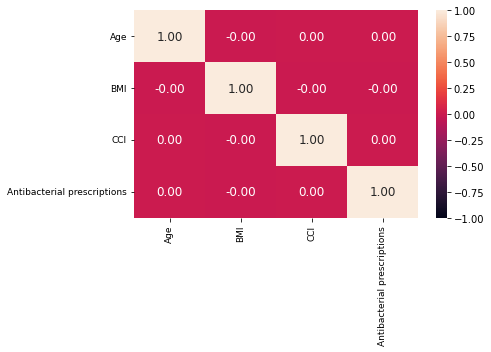

In [35]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_throat[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_throat/corr_throat.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [36]:
data_throat = data_throat[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                                   'antibacterial_brit', 'throat_ab_date', 'ab_type_cat', 'incdt_throat_date', 'date', 'period',
                                   'event_throat_admitted', 'duration_throat_admitted'
                                    ]]

In [37]:
#incident and prevalent infection 
data_throat_incdt = data_throat[data_throat['incdt_throat_date'] == 0]
data_throat_prevl = data_throat[data_throat['incdt_throat_date'] == 1]
#switch variable throat_ab_date into a binary variable
data_throat_incdt[['throat_ab_date']] = data_throat_incdt[['throat_ab_date']].where(data_throat_incdt[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)
data_throat_prevl[['throat_ab_date']] = data_throat_prevl[['throat_ab_date']].where(data_throat_prevl[['throat_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_throat_incdt_males = data_throat_incdt[data_throat_incdt['sex'] == 'male']
data_throat_incdt_females = data_throat_incdt[data_throat_incdt['sex'] == 'female']
data_throat_prevl_males = data_throat_prevl[data_throat_prevl['sex'] == 'male']
data_throat_prevl_females = data_throat_prevl[data_throat_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_throat_incdt_15_24 = data_throat_incdt[data_throat_incdt['age_cat'] == '15_24']
data_throat_incdt_25_34 = data_throat_incdt[data_throat_incdt['age_cat'] == '25_34']
data_throat_incdt_35_44 = data_throat_incdt[data_throat_incdt['age_cat'] == '35_44']
data_throat_incdt_45_54 = data_throat_incdt[data_throat_incdt['age_cat'] == '45_54']
data_throat_incdt_55_64 = data_throat_incdt[data_throat_incdt['age_cat'] == '55_64']
data_throat_incdt_65_74 = data_throat_incdt[data_throat_incdt['age_cat'] == '65_74']
data_throat_incdt_75_more = data_throat_incdt[data_throat_incdt['age_cat'] == '75_more']
data_throat_prevl_15_24 = data_throat_prevl[data_throat_prevl['age_cat'] == '15_24']
data_throat_prevl_25_34 = data_throat_prevl[data_throat_prevl['age_cat'] == '25_34']
data_throat_prevl_35_44 = data_throat_prevl[data_throat_prevl['age_cat'] == '35_44']
data_throat_prevl_45_54 = data_throat_prevl[data_throat_prevl['age_cat'] == '45_54']
data_throat_prevl_55_64 = data_throat_prevl[data_throat_prevl['age_cat'] == '55_64']
data_throat_prevl_65_74 = data_throat_prevl[data_throat_prevl['age_cat'] == '65_74']
data_throat_prevl_75_more = data_throat_prevl[data_throat_prevl['age_cat'] == '75_more']

#incident and prevalent infection stratified by time period categories
data_throat_incdt_prepandemic = data_throat_incdt[data_throat_incdt['date'] <= '2019-12']
data_throat_incdt_during_pandemic = data_throat_incdt[(data_throat_incdt['date'] >= '2020-03') & (data_throat_incdt['date']<= '2021-03')]
data_throat_incdt_post_2nd_lockdown = data_throat_incdt[data_throat_incdt['date'] <= '2021-04']
data_throat_prevl_prepandemic = data_throat_prevl[data_throat_prevl['date'] <= '2019-12']
data_throat_prevl_during_pandemic = data_throat_prevl[(data_throat_prevl['date'] >= '2020-03') & (data_throat_prevl['date']<= '2021-03')]
data_throat_prevl_post_2nd_lockdown = data_throat_prevl[data_throat_prevl['date'] <= '2021-04']

# no antibiotics and incident hospital admission
data_throat_no_abs_incdt = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_incdt = data_throat_no_abs_incdt[data_throat_no_abs_incdt['incdt_throat_date'] == 0]

# with antibiotics and incident hospital admission
data_throat_abs_incdt = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_incdt = data_throat_abs_incdt[data_throat_abs_incdt['incdt_throat_date'] == 0]

# no antibiotics and prevalent hospital admission
data_throat_no_abs_prevl = data_throat[data_throat['throat_ab_date'].isnull()]
data_throat_no_abs_prevl = data_throat_no_abs_prevl[data_throat_no_abs_prevl['incdt_throat_date'] == 1]

# with antibiotics and prevalent hospital admission
data_throat_abs_prevl = data_throat[data_throat['throat_ab_date'].notnull()]
data_throat_abs_prevl = data_throat_abs_prevl[data_throat_abs_prevl['incdt_throat_date'] == 1]

In [38]:
#store data for plotting hosp admission counts and percentages
%store data_throat
# save data
data_throat.to_csv('../output/hospitalisation_prediction_throat/data_throat.csv')

Stored 'data_throat' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident throat with no antibiotics

### 5-2- incident throat with antibiotics